In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.special import erf
from scipy.stats import gaussian_kde
import math
import random
from numpy import linalg as LA
from itertools import product
from utils import *
from plot import *
from copy import copy
from ceff_wrapper import *

## Ceff calculations

In [2]:
numerical_ceff_vals_3 = eval_ceff_range(2 * np.pi/3, 3, 'naive')
numerical_ceff_vals_4 = eval_ceff_range(np.pi/2, 4, 'naive')
numerical_ceff_vals_4_0 = eval_ceff_range(0, 4, 'naive')
numerical_ceff_vals_7 = eval_ceff_range(2 * np.pi/7, 7, 'naive')

analytical_inf_vals_3 = eval_ceff_range(2 * np.pi/3, 3, 'infsig')
analytical_inf_vals_4 = eval_ceff_range(np.pi/2, 4, 'infsig')
analytical_inf_vals_7 = eval_ceff_range(2 * np.pi/7, 7, 'infsig')

analytical_vals_3 = eval_ceff_range(2 * np.pi/3, 3, 'analytical')
analytical_vals_4 = eval_ceff_range(2 * np.pi/4, 4, 'analytical')
#analytical_vals_7 = eval_ceff_range(2 * np.pi/7, 7, 'analytical') #kernel will die with regular integration stepsize

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.82559402207125

In [3]:
se2_ceff_vals_3 = eval_ceff_range(2*np.pi/3, 3, 'SE(2) order 10')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


In [4]:
se2_ceff_vals_4 = eval_ceff_range(np.pi/2, 4, 'SE(2) order 10')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


In [5]:
se2_ceff_vals_4_0 = eval_ceff_range(0, 4, 'SE(2) order 10')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


In [6]:
se2_ceff_vals_7 = eval_ceff_range(2*np.pi/7, 7, 'SE(2) order 10')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


In [7]:
mining_minima_4 = eval_ceff_range(np.pi/2, 4, 'mining minima')
mining_minima_4_0 = eval_ceff_range(0, 4, 'mining minima')
mining_minima_7 = eval_ceff_range(2 * np.pi/7, 7, 'mining minima')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


In [8]:
gaussian_ceff_3 = eval_ceff_range(2 * np.pi/3, 3, 'gaussian')
gaussian_ceff_4 = eval_ceff_range(np.pi/2, 4, 'gaussian')
gaussian_ceff_7 = eval_ceff_range(2 * np.pi/7, 7, 'gaussian')

grid1_ceff_3 = eval_ceff_range(2 * np.pi/3, 3, 'grid1')
grid1_ceff_4 = eval_ceff_range(np.pi/2, 4, 'grid1')
grid2_ceff_4 = eval_ceff_range(np.pi/2, 4, 'grid2')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.82559402207125

In [9]:
grid1_ceff_kde_3 = eval_ceff_range(2 * np.pi/3, 3, 'grid1 kde')
grid1_ceff_kde_4 = eval_ceff_range(np.pi/2, 4, 'grid1 kde')
grid2_ceff_kde_4 = eval_ceff_range(np.pi/2, 4, 'grid2 kde')

grid1_ceff_4_0 = eval_ceff_range(0, 4, 'grid1')
grid2_ceff_4_0 = eval_ceff_range(0, 4, 'grid2')
grid1_ceff_kde_4_0 = eval_ceff_range(0, 4, 'grid1 kde')
grid2_ceff_kde_4_0 = eval_ceff_range(0, 4, 'grid2 kde')

grid1_ceff_7 = eval_ceff_range(2 * np.pi/7, 7, 'grid1')
grid2_ceff_7 = eval_ceff_range(2 * np.pi/7, 7, 'grid2')
grid1_ceff_kde_7 = eval_ceff_range(2 * np.pi/7, 7, 'grid1 kde')
grid2_ceff_kde_7 = eval_ceff_range(2 * np.pi/7, 7, 'grid2 kde')

lastlink1_3 = eval_ceff_range(2 * np.pi/3, 3, 'Last Link 1')
lastlink1_7 = eval_ceff_range(2 * np.pi/7, 7, 'Last Link 1')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001


/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:1020: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.

In [10]:
lastlink1_4 = eval_ceff_range(2 * np.pi/4, 4, 'Last Link 1')
lastlink1_4_0 = eval_ceff_range(0, 4, 'Last Link 1')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


In [11]:
lastlink2_4 = eval_ceff_range(np.pi/2, 4, 'Last Link 2')
lastlink2_4_0 = eval_ceff_range(0, 4, 'Last Link 2')
lastlink2_7 = eval_ceff_range(2*np.pi/7, 7, 'Last Link 2')

0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795
0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0
0.001
0.003593813663804626
0.01291549665014884
0.046415888336127795


/Users/ramyar/Dropbox/GradSchool/Research/toyfold/numerical_ceff/utils.py:57: RuntimeWarning: invalid value encountered in sqrt
  sum1 = np.sqrt(-(b**2 * sum1))


0.1668100537200059
0.5994842503189409
2.1544346900318843
7.742636826811277
27.825594022071257
100.0


## Ceff graphs

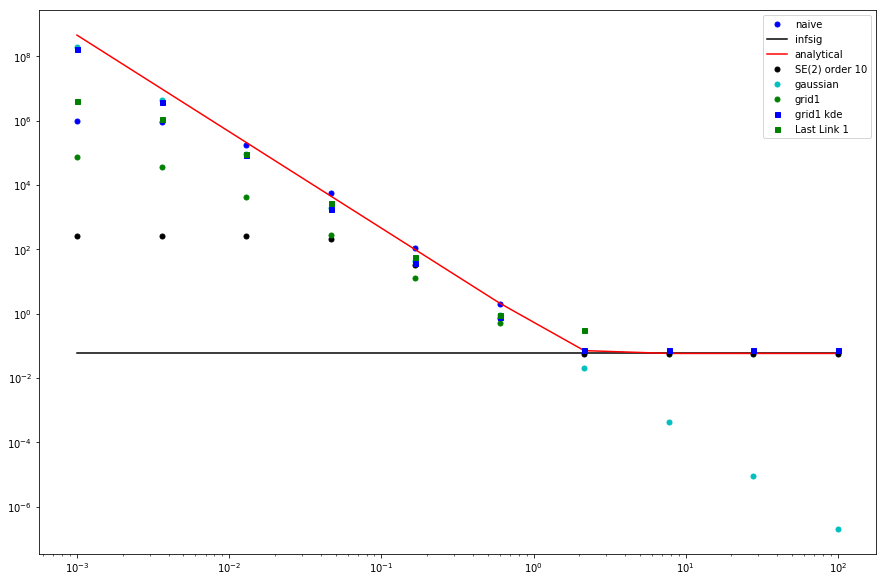

In [12]:
# Three links
ceff_lists_3 = [numerical_ceff_vals_3, analytical_inf_vals_3, analytical_vals_3, se2_ceff_vals_3, \
                gaussian_ceff_4, grid1_ceff_4, grid1_ceff_kde_4, lastlink1_4]
label_list_3 = ['naive', 'infsig', 'analytical', 'SE(2) order 10', 'gaussian',\
                'grid1', 'grid1 kde', 'Last Link 1']
plot_ceffs(ceff_lists_3, label_list_3, fig_size=(15, 10))

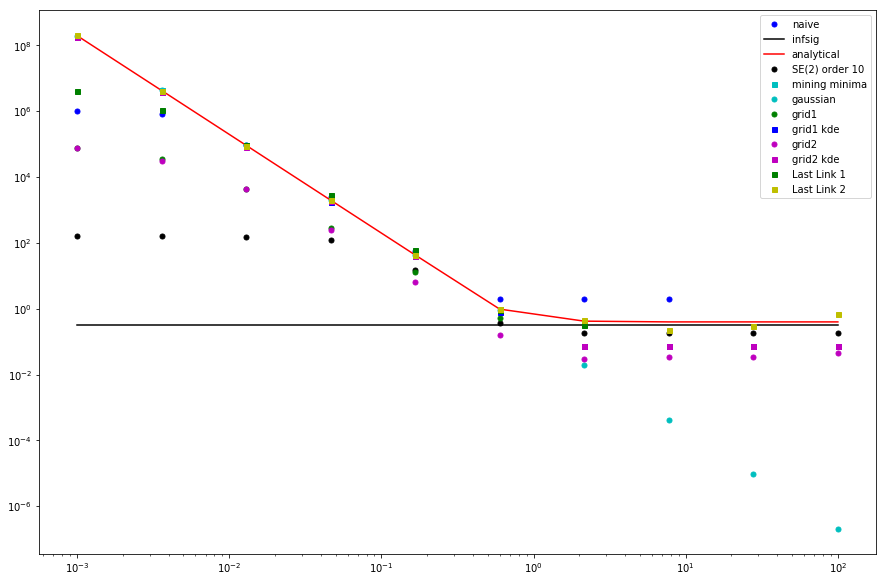

In [13]:
# Four links
ceff_lists_4 = [numerical_ceff_vals_4, analytical_inf_vals_4, analytical_vals_4, se2_ceff_vals_4, \
                mining_minima_4, gaussian_ceff_4, grid1_ceff_4, grid1_ceff_kde_4, grid2_ceff_4, \
                grid2_ceff_kde_4, lastlink1_4, lastlink2_4]
label_list_4 = ['naive', 'infsig', 'analytical', 'SE(2) order 10', 'mining minima', 'gaussian',\
                'grid1', 'grid1 kde', 'grid2', 'grid2 kde', 'Last Link 1', 'Last Link 2']
plot_ceffs(ceff_lists_4, label_list_4, fig_size=(15, 10))

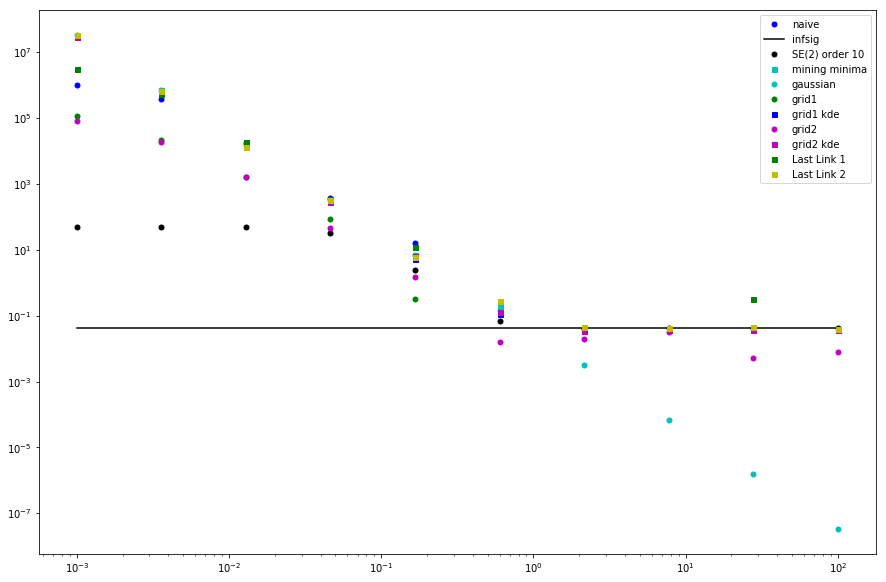

In [14]:
# Seven links
ceff_lists_7 = [numerical_ceff_vals_7, analytical_inf_vals_7, se2_ceff_vals_7, \
                mining_minima_7, gaussian_ceff_7, grid1_ceff_7, grid1_ceff_kde_7, grid2_ceff_7, \
                grid2_ceff_kde_7, lastlink1_7, lastlink2_7] # left out analytical_vals_7 due to compute
label_list_7 = ['naive', 'infsig', 'SE(2) order 10', 'mining minima', 'gaussian', \
                'grid1', 'grid1 kde', 'grid2', 'grid2 kde', 'Last Link 1', 'Last Link 2']
plot_ceffs(ceff_lists_7, label_list_7, fig_size=(15, 10))

/Users/ramyar/Dropbox/GradSchool/Research/toyfold/numerical_ceff/plot.py:29: RuntimeWarning: invalid value encountered in less
  ceff_list[ceff_list < 10**cutoff] = 0


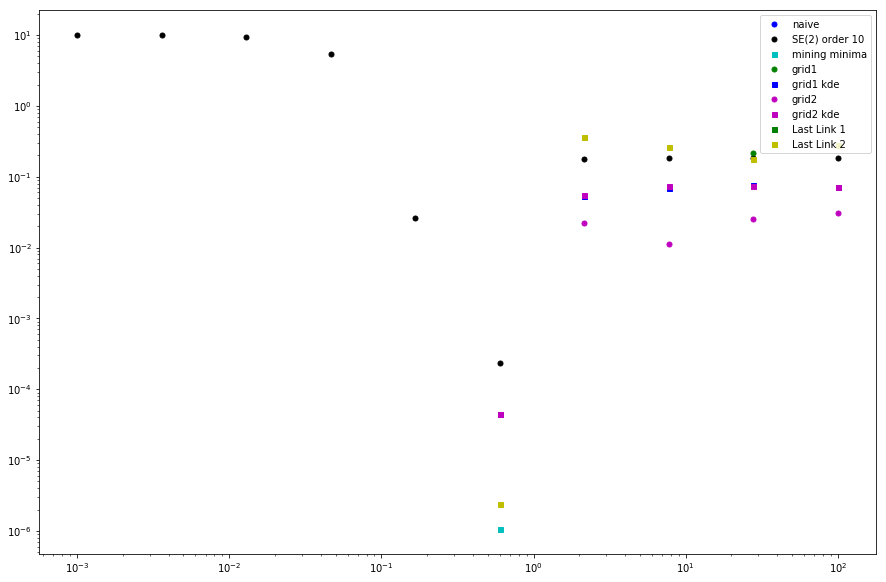

In [15]:
# Four links with theta_0 = 0
ceff_lists_4_0 = [numerical_ceff_vals_4_0, se2_ceff_vals_4_0, \
                mining_minima_4_0, grid1_ceff_4_0, grid1_ceff_kde_4_0, grid2_ceff_4_0, \
                grid2_ceff_kde_4_0, lastlink1_4_0, lastlink2_4_0]
label_list_4_0 = ['naive', 'SE(2) order 10', 'mining minima', \
                'grid1', 'grid1 kde', 'grid2', 'grid2 kde', 'Last Link 1', 'Last Link 2']
plot_ceffs(ceff_lists_4_0, label_list_4_0, fig_size=(15, 10), cutoff=-10)